In [1]:
from utils2d import check_tensorflow_gpu, check_torch_gpu
check_tensorflow_gpu()
check_torch_gpu()

from tensorflow.keras.layers import Layer, Dense, MultiHeadAttention, LayerNormalization, Dropout

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: Python39 | Python version: 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080



In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras.backend as K
from keras import Model
from keras.layers import Input, MaxPooling2D, LeakyReLU, Conv2D, BatchNormalization, Reshape, UpSampling3D

In [3]:
poro = np.load('simulations2D/data/poro.npy')
perm = np.load('simulations2D/data/perm.npy')
facies = np.load('simulations2D/data/facies.npy')
wells = np.load('simulations2D/data/wells.npy')
saturation = np.load('simulations2D/data/saturation.npy')
print(saturation.shape, poro.shape, perm.shape, facies.shape, wells.shape)

poro_n = MinMaxScaler().fit_transform(poro.T).T
perm_n = MinMaxScaler().fit_transform(perm.T).T
facies_n = MinMaxScaler().fit_transform(facies.T).T
saturation_n = MinMaxScaler().fit_transform(saturation.reshape(1000,50*128*128)).reshape(1000,50,128*128)

X_data = np.concatenate([np.expand_dims(poro_n, 1), np.expand_dims(perm_n, 1), 
                         np.expand_dims(facies_n, 1), np.expand_dims(wells, 1)], 1).reshape(1000,4,128,128)
y_data = saturation_n.reshape(1000,50,128,128)
print(X_data.shape, y_data.shape)

(1000, 50, 16384) (1000, 16384) (1000, 16384) (1000, 16384) (1000, 16384)
(1000, 4, 128, 128) (1000, 50, 128, 128)


In [4]:
X_train, y_train = np.moveaxis(X_data[:750], 1, -1), np.moveaxis(y_data[:750], 1, -1)
X_test,  y_test  = np.moveaxis(X_data[750:], 1, -1), np.moveaxis(y_data[750:], 1, -1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(750, 128, 128, 4) (750, 128, 128, 50)
(250, 128, 128, 4) (250, 128, 128, 50)


In [18]:
class VisionTransformerLayer(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
        super(VisionTransformerLayer, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.multihead_attention = MultiHeadAttention(num_heads=self.num_heads,
                                                      key_dim=self.embed_dim)
        self.mlp_block = tf.keras.Sequential([
            Dense(self.mlp_dim, activation='gelu'),
            Dense(self.embed_dim)
        ])
        self.layer_norm1 = LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.dropout_rate)
        self.dropout2 = Dropout(self.dropout_rate)
        
    def call(self, inputs):
        # Apply multi-head self-attention
        attention_output = self.multihead_attention(query=inputs,
                                                    value=inputs,
                                                    key=inputs)
        
        # Apply dropout and layer normalization
        attention_output = self.layer_norm1(inputs + self.dropout1(attention_output))
        
        # Apply MLP
        mlp_output = self.mlp_block(attention_output)
        
        # Apply dropout and layer normalization
        mlp_output = self.layer_norm2(mlp_output + self.dropout2(mlp_output))
        
        return mlp_output

In [54]:
def make_model():
    K.clear_session()

    def down_conv(inp, ch, slope=0.3):
        x = Conv2D(ch, (3,3), padding='same')(inp)
        x = LeakyReLU(slope)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        return x
    
    def up_conv(inp, ch, slope=0.3):
        x = Conv2D(ch, (3,3), padding='same')(inp)
        x = LeakyReLU(slope)(x)
        x = UpSampling3D((1,2,2))(x)
        x = BatchNormalization()(x)
        return x

    inp = Input(shape=(128,128,4))
    _ = down_conv(inp, 16)
    _ = down_conv(_, 64)
    _ = down_conv(_, 128)

    x = VisionTransformerLayer(50, 4, 256, 0.1)(_)
    _ = Reshape((50,16,16,1))(x)

    _ = up_conv(_, 1)
    _ = up_conv(_, 1)
    _ = up_conv(_, 1)

    out = Reshape((128,128,50))(_)

    return Model(inp, x), Model(inp, out)

enc, model = make_model()
#model.summary()

In [55]:
opt = tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

fit = model.fit(X_train, y_train,
                    shuffle = True,
                    epochs = 100,
                    validation_split = 0.2,
                    batch_size = 50,
                    verbose = 0)

In [56]:
y_test_pred  = model.predict(X_test)
y_test_pred.shape

8/8 [==============================] - 1s 16ms/step


(250, 128, 128, 50)

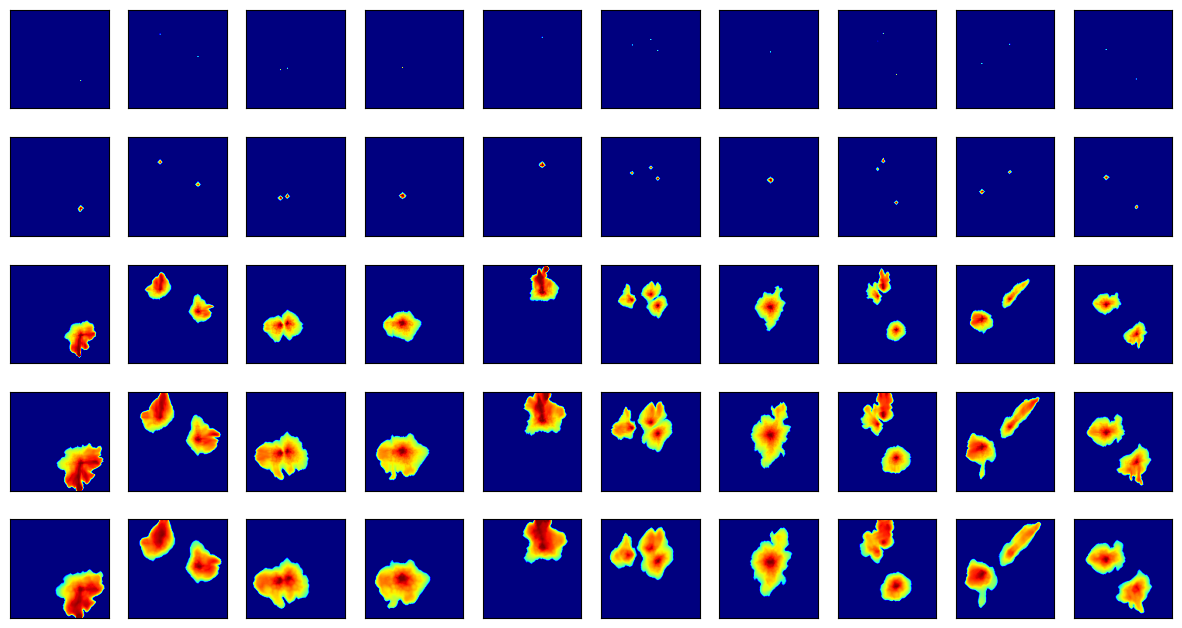

In [57]:
fig, axs = plt.subplots(5, 10, figsize=(15,8))
for i in range(5):
    for j in range(10):
        axs[i,j].imshow(y_test[j,:,:,i*10], 'jet')
        axs[i,j].set(xticks=[], yticks=[])
plt.show()

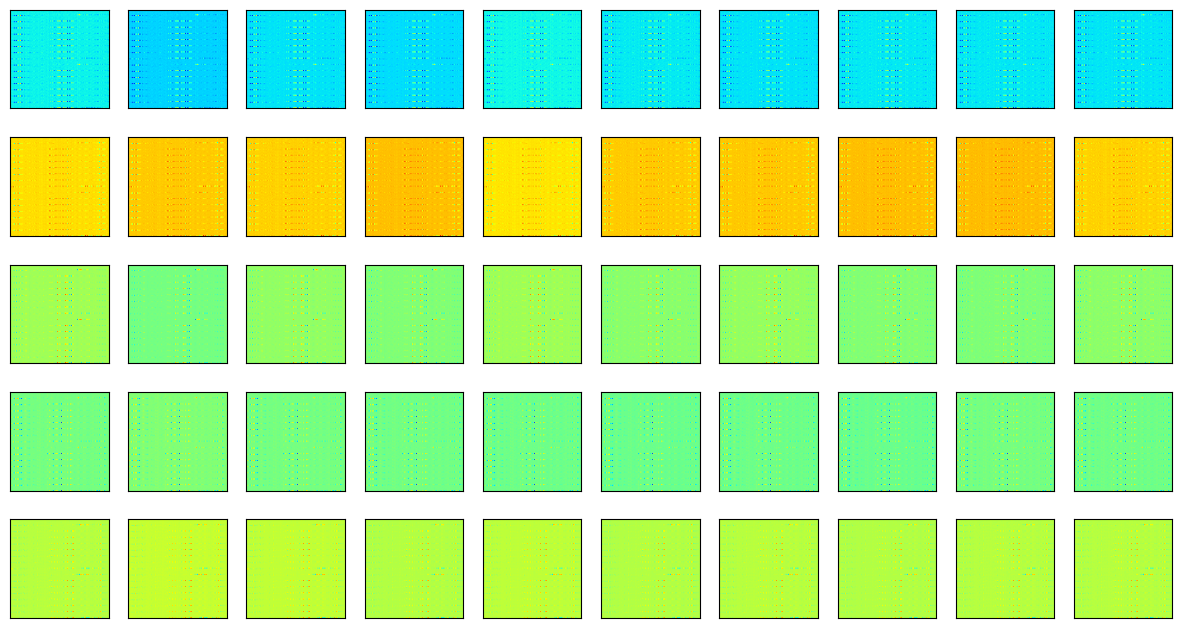

In [58]:
fig, axs = plt.subplots(5, 10, figsize=(15,8))
for i in range(5):
    for j in range(10):
        axs[i,j].imshow(y_test_pred[j,:,:,i*10], 'jet')
        axs[i,j].set(xticks=[], yticks=[])
plt.show()